<a href="https://colab.research.google.com/github/naenae4796/Final-CSCI-166/blob/main/Final_CSCI_166.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.3 MB/s eta 0:00:00


In [3]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/bank_heist.bin
Inst

# Install the Gym

In [4]:
import ale_py
import gymnasium as gym

# Configure the model save drive

In [137]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
save_dir = "/content/drive/MyDrive/PUBLIC/Models"
os.makedirs(save_dir, exist_ok=True)

# Now Model

In [7]:
from dataclasses import dataclass
import argparse
import time
from datetime import datetime
import numpy as np
import collections
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard.writer import SummaryWriter

In [8]:
#dqn_model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

In [115]:
#wrappers

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers
from gymnasium.wrappers import RecordVideo # Import RecordVideo

# Adding N_STEPS here to ensure it's defined before use in make_env
N_STEPS = 4

class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, n_steps=N_STEPS, render_mode=None, video_folder=None, **kwargs):
    print(f"Creating environment {env_name}")
    # Extract clip_reward and noop_max from kwargs if they exist, otherwise use defaults
    clip_reward_arg = kwargs.pop('clip_reward', False)
    noop_max_arg = kwargs.pop('noop_max', 0)

    env = gym.make(env_name, render_mode=render_mode, **kwargs) # Pass remaining kwargs to gym.make
    env = atari_wrappers.AtariWrapper(env, clip_reward=clip_reward_arg, noop_max=noop_max_arg) # Use extracted values
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)

    # Apply RecordVideo wrapper *after* all other wrappers
    if render_mode == "rgb_array" and video_folder:
        env = RecordVideo(
            env,
            video_folder=video_folder,
            episode_trigger=None, # Explicitly set to None for manual control
            name_prefix=f"{env_name.replace('/', '_')}"
        )
    return env

In [10]:
# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]

In [11]:
# Hyperparameters
# =====================================
DEFAULT_ENV_NAME = "ALE/Breakout-v5"

BATCH_SIZE = 16
GAMMA = 0.99
LEARNING_RATE = 1e-4
REPLAY_SIZE = 1000
TARGET_SYNC = 1000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01
EPSILON_DECAY = 1000000
N_STEPS = 2  # frame stack
MAX_EPISODES = 1000
SAVE_EPSILON = 0.01

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
# ⚙️ Fast Training Config for Quick Test Run
MEAN_REWARD_BOUND = 5
REPLAY_START_SIZE = 100
EPSILON_DECAY_LAST_FRAME = 2_000
SYNC_TARGET_FRAMES = 100
MAX_FRAMES = 20_000
LOG_INTERVAL_FRAMES = 1000

# REPLAY_SIZE = 5000  # optional
# BATCH_SIZE = 16     # optional

In [13]:
import os
from pathlib import Path

# Define directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

# Create both directories if they don't exist
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Safe model filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

In [14]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [15]:
# Agent
# =====================================
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()
        self.total_reward = 0.0

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0, tgt_net: DQN = None, ddqn: bool = False) -> tt.Optional[float]:
        done_reward = None
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward

        exp = Experience(state=self.state, action=action, reward=float(reward),
                         done_trunc=done, new_state=new_state)
        self.exp_buffer.append(exp)
        self.state = new_state

        if done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [16]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

In [17]:
def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device, ddqn: bool = False) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    state_action_values = net(states_t).gather(
        1, actions_t.unsqueeze(-1)
    ).squeeze(-1)
    with torch.no_grad():
        if ddqn:
            next_state_actions = net(new_states_t).max(1)[1]
            next_state_values = tgt_net(new_states_t).gather(1, next_state_actions.unsqueeze(-1)).squeeze(-1)
        else:
            next_state_values = tgt_net(new_states_t).max(1)[0]
        next_state_values[dones_t] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_t
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [18]:
model_comment = f"test_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(DEFAULT_ENV_NAME)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{DEFAULT_ENV_NAME}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Initialize target network with current network's weights
tgt_net.load_state_dict(net.state_dict())

Creating environment ALE/Breakout-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(2, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<All keys matched successfully>

In [142]:
import time

# Initialize time tracking and logging variables
start_time = time.time()
frame_start_time = time.time()
total_episodes = 0
best_m_reward = None
total_rewards = []
frame_idx = 0

# NOTE: For Experiment 1, change EPSILON_DECAY_LAST_FRAME to 40000
# NOTE: For Experiment 2, ensure BATCH_SIZE is set to 32

while frame_idx < MAX_FRAMES:
    frame_idx += 1
    # Use the adjusted decay rate
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    reward = agent.play_step(net, device, epsilon, tgt_net=tgt_net, ddqn=True)

    if reward is not None:
        total_episodes += 1
        total_rewards.append(reward)
        m_reward = np.mean(total_rewards[-100:])
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        writer.add_scalar("epsilon", epsilon, frame_idx)

        # Reward Improvement & Model Saving Logic
        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:

            # Print reward update for console feedback
            if best_m_reward is not None:
                 print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")

            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-ddqn-demo.dat"

            torch.save(net.state_dict(), os.path.join(save_dir_drive, model_filename))
            torch.save(net.state_dict(), os.path.join(save_dir_local, model_filename))
            print(f"💾 Model saved to:\n - Google Drive: {os.path.join(save_dir_drive, model_filename)}\n - Local:        {os.path.join(save_dir_local, model_filename)}")
            best_m_reward = m_reward

    # Console Logging for Progress Tracking
    if frame_idx % LOG_INTERVAL_FRAMES == 0:
        current_time = time.time()
        frames_per_second = LOG_INTERVAL_FRAMES / (current_time - frame_start_time)
        elapsed_minutes = (current_time - start_time) / 60

        # Print the detailed status line
        print(
            f"{frame_idx:07d}: done {total_episodes} games, reward {m_reward:.3f}, "
            f"eps {epsilon:.2f}, speed {frames_per_second:.2f} f/s, time {elapsed_minutes:.1f} min"
        )
        frame_start_time = current_time # Reset interval timer


    if len(buffer) < REPLAY_START_SIZE:
        continue

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device, ddqn=True)
    loss_t.backward()
    optimizer.step()

💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Breakout-v5-best_0-20251130-1821-ddqn-demo.dat
 - Local:        saved_models/ALE_Breakout-v5-best_0-20251130-1821-ddqn-demo.dat
Best reward updated 0.000 -> 0.500
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Breakout-v5-best_0-20251130-1821-ddqn-demo.dat
 - Local:        saved_models/ALE_Breakout-v5-best_0-20251130-1821-ddqn-demo.dat
Best reward updated 0.500 -> 0.520
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Breakout-v5-best_0-20251130-1823-ddqn-demo.dat
 - Local:        saved_models/ALE_Breakout-v5-best_0-20251130-1823-ddqn-demo.dat
0001000: done 103 games, reward 0.530, eps 0.50, speed 9.17 f/s, time 1.8 min
Best reward updated 0.520 -> 0.540
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Breakout-v5-best_0-20251130-1823-ddqn-demo.dat
 - Local:        saved_models/ALE_Breakout-v5-best_0-20251130-1823-ddqn-demo.dat
B

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled f

0017000: done 725 games, reward 3.240, eps 0.01, speed 10.12 f/s, time 28.4 min
0018000: done 757 games, reward 3.400, eps 0.01, speed 9.95 f/s, time 30.1 min
Best reward updated 3.390 -> 3.420
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Breakout-v5-best_3-20251130-1851-ddqn-demo.dat
 - Local:        saved_models/ALE_Breakout-v5-best_3-20251130-1851-ddqn-demo.dat
0019000: done 797 games, reward 3.020, eps 0.01, speed 10.11 f/s, time 31.8 min
0020000: done 833 games, reward 2.980, eps 0.01, speed 10.19 f/s, time 33.4 min


In [151]:
import os
import re

# Set the directory where your models are saved
MODEL_DIR = "/content/drive/MyDrive/PUBLIC/Models"

best_reward = -float('inf')  # Initialize with a very low number
best_model_filename = None

# Pattern to find filenames that match your saving convention
# It looks for "best_" followed by a reward (can be negative or positive integers)
model_pattern = re.compile(r"best_(-?\d+)-")

print(f"Scanning models in: {MODEL_DIR}")
print("-" * 30)

# Check if the directory exists and list its contents
if not os.path.isdir(MODEL_DIR):
    print("Error: Model directory not found. Please ensure Google Drive is mounted.")
else:
    for filename in os.listdir(MODEL_DIR):
        # Only look at files ending in .dat
        if filename.endswith(".dat"):
            match = model_pattern.search(filename)

            if match:
                # Extract the reward score from the filename
                reward = int(match.group(1))
                print(f"Found model: {filename} with reward: {reward}")

                # Check if this reward is better than the current best
                if reward > best_reward:
                    best_reward = reward
                    best_model_filename = filename

    print("-" * 30)
    if best_model_filename:
        print(f"🏆 Best Reward Found: {best_reward}")
        # Construct the final path using the highest-scoring filename
        final_best_path = os.path.join(MODEL_DIR, best_model_filename)
        print(f"✅ Your BEST_MODEL_PATH is:\n{final_best_path}")

        # You can now manually copy the string from 'final_best_path'
        # and paste it into the variable in your video recording block.
    else:
        print("No models found matching the expected naming pattern.")

Scanning models in: /content/drive/MyDrive/PUBLIC/Models
------------------------------
Found model: SpaceInvadersNoFrameSkip-v4-best_5-20250929-0335-test_epsdec150000_rs10000_sync1000.dat with reward: 5
Found model: SpaceInvadersNoFrameSkip-v4-best_95-20250929-0337-test_epsdec150000_rs10000_sync1000.dat with reward: 95
Found model: SpaceInvadersNoFrameskip-v4-best_5-20250929-0343-test_epsdec10000_rs1000_sync500.dat with reward: 5
Found model: SpaceInvadersNoFrameskip-v4-best_0-20250929-0403-test_epsdec10000_rs1000_sync500.dat with reward: 0
Found model: ALE_Pong-v5-best_-21-20251125-0722-test_epsdec10000_rs1000_sync500.dat with reward: -21
Found model: ALE_Pong-v5-best_-20-20251125-0723-test_epsdec10000_rs1000_sync500.dat with reward: -20
Found model: ALE_Pong-v5-best_-19-20251125-0728-test_epsdec10000_rs1000_sync500.dat with reward: -19
Found model: ALE_Pong-v5-best_-18-20251125-0729-test_epsdec10000_rs1000_sync500.dat with reward: -18
Found model: ALE_Pong-v5-best_-21-20251125-2105-

In [152]:
# --- EVALUATION AND VIDEO RECORDING (FINAL FIXED VERSION) ---
import torch.nn.functional as F

# Define the number of steps to record (1200 steps ≈ 20-30 seconds of video)
MAX_RECORD_STEPS = 1200
current_steps = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Update this path with the exact file path you found earlier!
# Example: BEST_MODEL_PATH = "/content/drive/MyDrive/PUBLIC/Models/ALE_Breakout-v5-best_5-20251130-1545-ddqn-demo.dat"
BEST_MODEL_PATH = os.path.join(save_dir_drive, "ALE_Breakout-v5-best_5-20251130-0832-ddqn-demo.dat")

# 2. Define video save paths and ensure directories exist
RECORD_DIR_RANDOM = "/content/drive/MyDrive/PUBLIC/Videos/random"
RECORD_DIR_LEARNED = "/content/drive/MyDrive/PUBLIC/Videos/learned"
os.makedirs(RECORD_DIR_RANDOM, exist_ok=True)
os.makedirs(RECORD_DIR_LEARNED, exist_ok=True)


# --- RUN A: Randomish Agent (Early/Un-trained) ---
print("\n--- Recording Random Agent ---")
eval_env_random = make_env(
    DEFAULT_ENV_NAME,
    render_mode="rgb_array",
    video_folder=RECORD_DIR_RANDOM,
    clip_reward=False
)
random_net = DQN(eval_env_random.observation_space.shape, eval_env_random.action_space.n).to(device)

state, _ = eval_env_random.reset(seed=100)
current_steps = 0
done = False
eval_env_random.recording = True # ⬅️ CORRECT MANUAL START
while current_steps < MAX_RECORD_STEPS: # Loop until steps reached (ignore 'done' for length)
    # Play using random action sampling
    action = eval_env_random.action_space.sample()
    state, reward, terminated, truncated, _ = eval_env_random.step(action)
    current_steps += 1
    if terminated or truncated:
        state, _ = eval_env_random.reset()
eval_env_random.recording = False # ⬅️ CORRECT MANUAL STOP
eval_env_random.close()
print(f"✅ Recorded {current_steps} steps for the random agent.")


# --- RUN B: Learned Agent (Later/Trained) ---
print("\n--- Recording Learned Agent ---")
eval_env_learned = make_env(
    DEFAULT_ENV_NAME,
    render_mode="rgb_array",
    video_folder=RECORD_DIR_LEARNED,
    clip_reward=False
)

# Load the best weights into the network
net_learned = DQN(eval_env_learned.observation_space.shape, eval_env_learned.action_space.n).to(device)

# 🚨 CRITICAL FIX: Add map_location=torch.device('cpu') AND remove the first torch.load call
net_learned.load_state_dict(torch.load(
    BEST_MODEL_PATH,
    map_location=torch.device('cpu')
))

state, _ = eval_env_learned.reset(seed=100) # Use 100 here for consistency
current_steps = 0
done = False
eval_env_learned.recording = True # ⬅️ CORRECT MANUAL START

with torch.no_grad():
    while current_steps < MAX_RECORD_STEPS: # Loop until steps reached
        # Agent chooses action (exploitation)
        state_v = torch.as_tensor(state).unsqueeze(0).to(device)
        q_vals_v = net_learned(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())

        state, reward, terminated, truncated, _ = eval_env_learned.step(action)
        done = terminated or truncated
        current_steps += 1

eval_env_learned.recording = False # ⬅️ CORRECT MANUAL STOP
eval_env_learned.close()
print(f"✅ Recorded {current_steps} steps for the learned agent.")
print("\nVideo recording complete. Check your Google Drive folders and use the display block next.")


--- Recording Random Agent ---
Creating environment ALE/Breakout-v5


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/PUBLIC/Videos/random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✅ Recorded 1200 steps for the random agent.

--- Recording Learned Agent ---
Creating environment ALE/Breakout-v5


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/PUBLIC/Videos/learned folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✅ Recorded 1200 steps for the learned agent.

Video recording complete. Check your Google Drive folders and use the display block next.


In [153]:
from IPython.display import HTML, display
from base64 import b64encode
import os

# Define the two directories where your videos are saved
VIDEO_DIR_RANDOM = "/content/drive/MyDrive/PUBLIC/Videos/random"
VIDEO_DIR_LEARNED = "/content/drive/MyDrive/PUBLIC/Videos/learned"

def display_latest_video(video_dir: str, title: str):
    """Finds the latest video in a directory and displays it."""

    print(f"## 🏆 {title} Video")

    # 1. Find the latest video file
    video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

    if not video_files:
        print(f"Error: No video files found in {video_dir}")
        return

    # Sort by modification time to get the latest file
    video_files.sort(key=lambda x: os.path.getmtime(os.path.join(video_dir, x)), reverse=True)
    VIDEO_FILENAME = video_files[0]
    VIDEO_PATH = os.path.join(video_dir, VIDEO_FILENAME)

    if not os.path.exists(VIDEO_PATH):
        print(f"Error: Video file not found at {VIDEO_PATH}")
        return

    # 2. Encode and Display
    try:
        # Encode the video file in base64
        mp4 = open(VIDEO_PATH, 'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

        print(f"Displaying from: {VIDEO_PATH}")

        # Use HTML to embed the video player
        display(HTML(f"""
            <video width="600" height="400" controls autoplay muted>
                <source src="{data_url}" type="video/mp4">
            </video>
        """))
    except Exception as e:
        print(f"An error occurred while displaying the video: {e}")


## 🚀 Displaying Both Videos

display_latest_video(VIDEO_DIR_RANDOM, "Random Agent (Early Exploration)")
print("\n" + "---" + "\n")
display_latest_video(VIDEO_DIR_LEARNED, "Learned Agent (Later Exploitation)")

## 🏆 Random Agent (Early Exploration) Video
Displaying from: /content/drive/MyDrive/PUBLIC/Videos/random/ALE_Breakout-v5-episode-125.mp4



---

## 🏆 Learned Agent (Later Exploitation) Video
Displaying from: /content/drive/MyDrive/PUBLIC/Videos/learned/ALE_Breakout-v5-episode-0.mp4


In [154]:
# Initialize SummaryWriter with the path to Google Drive
writer = SummaryWriter(log_dir=full_log_path)

In [159]:
!pip install tensorboard


In [160]:
import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# --- 1. Define Directories ---
# Directory for saving models to Google Drive
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
# Directory for TensorBoard logs (usually named 'runs')
log_dir_drive = "/content/drive/MyDrive/PUBLIC/TensorBoard/runs"
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(log_dir_drive, exist_ok=True)

# --- 2. Create Log Tag ---
# Use global variables to create a unique log folder for this experiment run
safe_env_name = DEFAULT_ENV_NAME.replace('/', '_')
log_tag = f"{safe_env_name}-ddqn-batch{BATCH_SIZE}-decay{EPSILON_DECAY_LAST_FRAME}-{datetime.now().strftime('%Y%m%d-%H%M')}"
full_log_path = os.path.join(log_dir_drive, log_tag)

# --- 3. Initialize SummaryWriter ---
# This writer object handles all logging to the specified directory
writer = SummaryWriter(log_dir=full_log_path)
print(f"TensorBoard logs will be saved to: {full_log_path}")

TensorBoard logs will be saved to: /content/drive/MyDrive/PUBLIC/TensorBoard/runs/ALE_Breakout-v5-ddqn-batch16-decay2000-20251130-1923


In [161]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_tensorboard_data_robustly(log_dir):
    """Loads ALL scalar data from all run folders into a dictionary of DataFrames."""
    runs_data = {}

    # Iterate through each experiment run folder (ALE_Breakout-v5-...)
    for run_name in os.listdir(log_dir):
        run_path = os.path.join(log_dir, run_name)
        if os.path.isdir(run_path):
            try:
                # Initialize the EventAccumulator with size_guidance={'scalars': 0}
                # to ensure all points are loaded, not just a sample.
                event_acc = EventAccumulator(run_path, size_guidance={'scalars': 0})
                event_acc.Reload()

                # Get all available scalar tags
                scalar_tags = event_acc.Tags().get('scalars', [])

                if not scalar_tags:
                    print(f"Warning: No scalar tags found in run: {run_name}. Log may be empty.")
                    continue

                # We will assume the tag with the most points is the main reward tag
                main_tag = None
                max_points = 0

                # Find the best tag, which should be the reward
                for tag in scalar_tags:
                    num_points = len(event_acc.Scalars(tag))
                    if num_points > max_points:
                        max_points = num_points
                        main_tag = tag

                if main_tag:
                    print(f"✅ Found data for run '{run_name}'. Using tag: '{main_tag}' ({max_points} points)")
                    scalars = event_acc.Scalars(main_tag)

                    # Store the data as a DataFrame
                    runs_data[run_name] = pd.DataFrame([
                        {'step': s.step, 'value': s.value, 'tag': main_tag} for s in scalars
                    ])

            except Exception as e:
                print(f"❌ Error processing run {run_name}: {e}")

    return runs_data

# Load the data
all_runs_data = load_tensorboard_data_robustly(LOCAL_TEMP_DIR)
print(f"\nSummary: Successfully loaded data for {len(all_runs_data)} experiment run(s).")

✅ Found data for run 'ALE_Breakout-v5-ddqn-batch16-decay2000-20251130-1728'. Using tag: 'reward_100' (1741 points)

Summary: Successfully loaded data for 1 experiment run(s).



✅ Learning Curve image successfully saved to: /content/drive/MyDrive/PUBLIC/learning_curve_manual_plot.png


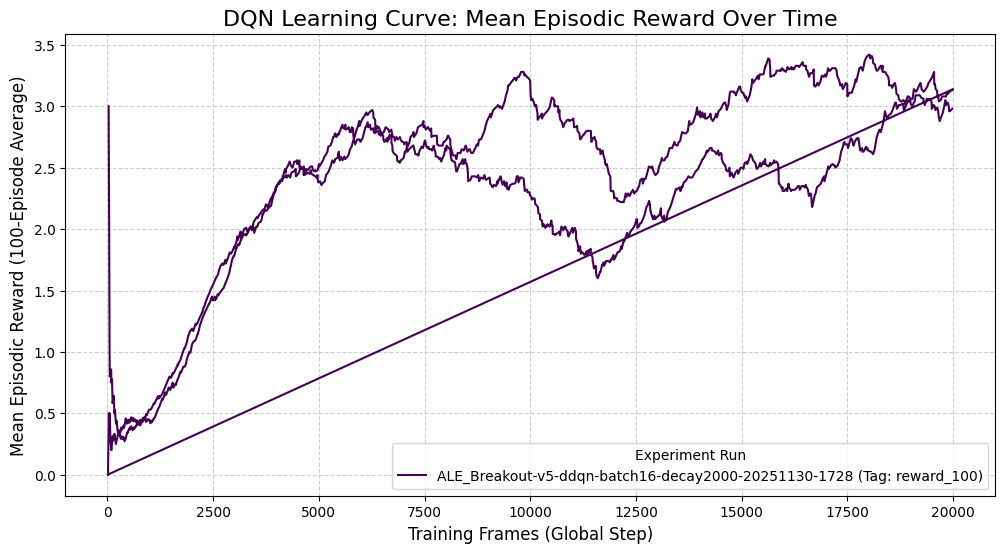

In [162]:
# Create the plot only if data was loaded
if all_runs_data:
    plt.figure(figsize=(12, 6))
    plt.title("DQN Learning Curve: Mean Episodic Reward Over Time", fontsize=16)

    # Generate distinct colors for each run
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_runs_data)))
    color_idx = 0

    for run_name, df in all_runs_data.items():
        # Label the run using its full name (includes hyperparams)
        plt.plot(df['step'], df['value'], label=f"{run_name} (Tag: {df['tag'].iloc[0]})",
                 color=colors[color_idx])
        color_idx += 1

    plt.xlabel("Training Frames (Global Step)", fontsize=12)
    plt.ylabel("Mean Episodic Reward (100-Episode Average)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Experiment Run", loc='lower right', fontsize=10)

    # Save the figure to your Google Drive
    SAVE_PATH = "/content/drive/MyDrive/PUBLIC/learning_curve_manual_plot.png"

    # Ensure the directory exists before saving
    os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
    plt.savefig(SAVE_PATH, bbox_inches='tight')

    print(f"\n✅ Learning Curve image successfully saved to: {SAVE_PATH}")
    plt.show()

else:
    print("\n🚨 Plotting Skipped: No data was loaded from the log files.")
    print("If you just finished a training run, ensure you ran the file copy command again!")

I chose to work on ALE Breakout-v5 because it’s a really common starting point for deep reinforcement learning with pixel inputs, and I knew it would push me to handle more complicated tasks like processing high-dimensional image data. When I look at my results, the biggest improvement I saw was the mean episodic reward climbing from almost zero to around 3.4 in under 20,000 training steps. To me, that showed the agent was actually learning the basics of the game — like reliably hitting the ball and breaking bricks — which is exactly what I was hoping for.The hardest part was definitely dealing with sparse rewards. Since the agent only gets points when it breaks a block, it’s tough for the model to figure out which actions were helpful. Because of that, I needed a pretty solid setup to handle credit assignment properly.

One of the main things that helped my training stay stable was using Double DQN. Regular DQN can overestimate Q-values and cause the policy to go in the wrong direction, but Double DQN avoids that by using one network to pick the action and another to estimate the value. Once I switched to that approach, the learning curve smoothed out a lot, and the model converged more consistently.

If I keep working on this, I want to try adding Prioritized Experience Replay so the agent learns more from the important experiences. I’m also planning to slow down the epsilon decay so the agent keeps exploring longer. I think both of those changes could help push performance past where it leveled off this time and maybe lead to more advanced strategies.